<h2>Importing prequiste</h2>

In [1]:
from __future__ import division

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import random
import cv2
import math
import numpy as np
from scipy import pi
import scipy
import scipy.misc

from subprocess import call
from datetime import datetime
from itertools import islice
import matplotlib.pyplot as plt 
import tensorflow as tf          

<h2> EDA</h2>

In [2]:
img_data = [] #specifing for image data
angle_data = [] #specifing for angle steering wheel data

In [3]:
#defining function to load our datas from data.txt
def load_dataset():
    #reading data from data.txt
    with open("driving_dataset/data.txt") as file:
        for lines in file:
            img_data.append('driving_dataset/' + lines.split()[0])
            # the paper by Nvidia uses the inverse of the turning radius,
            # but steering wheel angle is proportional to the inverse of turning radius
            # so the steering wheel angle in radians is used as the output
            angle_data.append(float(lines.split()[1])*scipy.pi/180)            

In [4]:
load_dataset()

#splitting datas into train and test 70-30 
train_images = img_data[:int(len(img_data)*0.7)]
train_angle = angle_data[:int(len(angle_data)*0.7)]

test_images = img_data[-int(len(img_data)*0.3):]
test_angle = angle_data[-int(len(angle_data)*0.3):]

In [5]:
num_of_images = len(img_data)
print("Total number of images: ",num_of_images)

num_of_train_images = len(train_images)
print("Total number of images for training: ",num_of_train_images)

num_of_test_images = len(test_images)
print("Total number of images for testing: ",num_of_test_images)

('Total number of images: ', 45406)
('Total number of images for training: ', 31784)
('Total number of images for testing: ', 13621)


<h2>Histogram</h2>

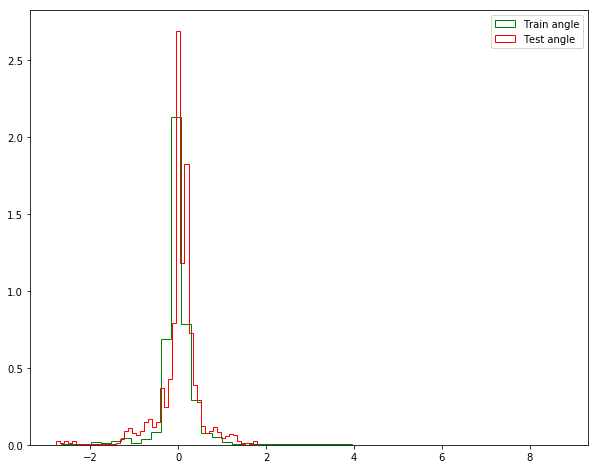

In [6]:
import numpy;
import warnings
warnings.filterwarnings("ignore")

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,8))
plt.hist(train_angle, bins=50, normed=1, color='green', histtype ='step',label='Train angle');
plt.hist(test_angle, bins=50, normed=1, color='red', histtype ='step',label='Test angle');
plt.legend()
plt.show()

<h2> Baseline Model </h2>

In [7]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_angle)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_angle-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(np.array(test_angle)-0)) )


Test_MSE(MEAN):0.241559
Test_MSE(ZERO):0.241108


As we can we are getting MSE around 0.223 for train and test split 70-30 i.e which is more then 0.19 that we have got for 80-20

<h2> Intializing weight , bias and convolution layer </h2>

In [8]:
#defining function for weight
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    #The generated values follow a normal distribution with specified mean and standard deviation, 
    #except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked
    return tf.Variable(initial)

#defining function for bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

#defining function for convolution layer parameter
def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

In [9]:
true_image_ln = tf.placeholder(tf.float32, shape=[None, 66, 200, 3],name="true_image_ln")
true_angle_ln = tf.placeholder(tf.float32, shape=[None, 1],name="true_angle_ln")

x_image_ln = true_image_ln

In [10]:
#first convolutional layer
W_conv1_ln = weight_variable([5, 5, 3, 24])
b_conv1_ln = bias_variable([24])

h_conv1_ln = tf.nn.relu(conv2d(x_image_ln, W_conv1_ln, 2) + b_conv1_ln)

#second convolutional layer
W_conv2_ln = weight_variable([5, 5, 24, 36])
b_conv2_ln = bias_variable([36])

h_conv2_ln = tf.nn.relu(conv2d(h_conv1_ln, W_conv2_ln, 2) + b_conv2_ln)

#third convolutional layer
W_conv3_ln = weight_variable([5, 5, 36, 48])
b_conv3_ln = bias_variable([48])

h_conv3_ln = tf.nn.relu(conv2d(h_conv2_ln, W_conv3_ln, 2) + b_conv3_ln)

#fourth convolutional layer
W_conv4_ln = weight_variable([3, 3, 48, 64])
b_conv4_ln = bias_variable([64])

h_conv4_ln = tf.nn.relu(conv2d(h_conv3_ln, W_conv4_ln, 1) + b_conv4_ln)

#fifth convolutional layer
W_conv5_ln = weight_variable([3, 3, 64, 64])
b_conv5_ln = bias_variable([64])

h_conv5_ln = tf.nn.relu(conv2d(h_conv4_ln, W_conv5_ln, 1) + b_conv5_ln)

#FCL 1
W_fc1_ln = weight_variable([1152, 1164])
b_fc1_ln = bias_variable([1164])

h_conv5_flat_ln = tf.reshape(h_conv5_ln, [-1, 1152])
h_fc1_ln = tf.nn.relu(tf.matmul(h_conv5_flat_ln, W_fc1_ln) + b_fc1_ln)

keep_prob_ln = tf.placeholder(tf.float32,name="keep_prob_ln")
h_fc1_drop_ln = tf.nn.dropout(h_fc1_ln, keep_prob_ln)

#FCL 2
W_fc2_ln = weight_variable([1164, 100])
b_fc2_ln = bias_variable([100])

h_fc2_ln = tf.nn.relu(tf.matmul(h_fc1_drop_ln, W_fc2_ln) + b_fc2_ln)

h_fc2_drop_ln = tf.nn.dropout(h_fc2_ln, keep_prob_ln)

#FCL 3
W_fc3_ln = weight_variable([100, 50])
b_fc3_ln = bias_variable([50])

h_fc3_ln = tf.nn.relu(tf.matmul(h_fc2_drop_ln, W_fc3_ln) + b_fc3_ln)

h_fc3_drop_ln = tf.nn.dropout(h_fc3_ln, keep_prob_ln)

#FCL 3
W_fc4_ln = weight_variable([50, 10])
b_fc4_ln = bias_variable([10])

h_fc4_ln = tf.nn.relu(tf.matmul(h_fc3_drop_ln, W_fc4_ln) + b_fc4_ln)

h_fc4_drop_ln = tf.nn.dropout(h_fc4_ln, keep_prob_ln)

#Output
W_fc5_ln = weight_variable([10, 1])
b_fc5_ln = bias_variable([1])

# linear activation function
predicted_angle_ln = tf.identity((tf.matmul(h_fc4_drop_ln, W_fc5_ln) + b_fc5_ln))

In [11]:
train_batch_pointer = 0
test_batch_pointer = 0

# Utility Functions
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_images[(train_batch_pointer + i) % num_of_train_images])[-150:], 
                                         [66, 200]) / 255.0)
        y_out.append([train_angle[(train_batch_pointer + i) % num_of_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadTestBatch(batch_size): 
    global test_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(test_images[(test_batch_pointer + i) % num_of_test_images])[-150:], 
                                         [66, 200]) / 255.0)
        y_out.append([test_angle[(test_batch_pointer + i) % num_of_test_images]])
    test_batch_pointer += batch_size
    return x_out, y_out

In [14]:
SAVEDIR = "/home/ajay/Applied_course/self_driving_car/Autopilot-TensorFlow-master/save/"
sess = tf.InteractiveSession()

In [15]:
start = datetime.now()
L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(true_angle_ln, predicted_angle_ln))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)

# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver()

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
previous_i = 0
previous_loss = 0

for epoch in range(epochs):
    for i in range(int(num_of_images/batch_size)):        
        xs, ys = LoadTrainBatch(batch_size)
        train_step.run(feed_dict={true_image_ln: xs, true_angle_ln: ys, keep_prob_ln: 0.50})
        if i % 10 == 0:            
            xs, ys = LoadTestBatch(batch_size)
            loss_value = loss.eval(feed_dict={true_image_ln:xs, true_angle_ln: ys, keep_prob_ln: 1.0})
            previous_loss = loss_value
            previous_i = i
            # print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

        # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={true_image_ln:xs, true_angle_ln: ys, keep_prob_ln: 1.0})
        summary_writer.add_summary(summary, epoch * num_of_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(SAVEDIR):
                os.makedirs(SAVEDIR)            
            checkpoint_path = os.path.join(SAVEDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)    
    print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + previous_i, previous_loss)) 
    print("Model saved in file: %s" % filename)
    print()

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

print("\nTime taken to train the model: ")
print(datetime.now() - start)
sess.close()

Epoch: 0, Step: 450, Loss: 0.440863
Model saved in file: /home/ajay/Applied_course/self_driving_car/Autopilot-TensorFlow-master/save/model.ckpt
()
Epoch: 1, Step: 550, Loss: 0.108497
Model saved in file: /home/ajay/Applied_course/self_driving_car/Autopilot-TensorFlow-master/save/model.ckpt
()
Epoch: 2, Step: 650, Loss: 0.0525254
Model saved in file: /home/ajay/Applied_course/self_driving_car/Autopilot-TensorFlow-master/save/model.ckpt
()
Epoch: 3, Step: 750, Loss: 0.0241816
Model saved in file: /home/ajay/Applied_course/self_driving_car/Autopilot-TensorFlow-master/save/model.ckpt
()
Epoch: 4, Step: 850, Loss: 0.0695357
Model saved in file: /home/ajay/Applied_course/self_driving_car/Autopilot-TensorFlow-master/save/model.ckpt
()
Epoch: 5, Step: 950, Loss: 0.0288018
Model saved in file: /home/ajay/Applied_course/self_driving_car/Autopilot-TensorFlow-master/save/model.ckpt
()
Epoch: 6, Step: 1050, Loss: 0.0115439
Model saved in file: /home/ajay/Applied_course/self_driving_car/Autopilot-Te

<h2> Making prediction from model</h2>

To run model for testing run test_output.py in command prompt